In [13]:
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import math
import time
import matplotlib.pyplot as plt

In [14]:
# -------------------------
# Environment & traffic params
# -------------------------
T_p = 1             # time quantum (seconds)
L = 300             # packet/bit size placeholder (not used explicitly)
Q_max = 60          # threshold for high queue
Q_threshold = 40   # threshold for low queue
W_max = 500         # max bandwidth (units treated as service capacity per second)
cycles = 24         # number of cycles per episode (hours)
second_in_hour = 3600            # seconds per cycle (1 hour)
episodes = 1000      # reduce for faster runs; set to 1000 for full run
hours_in_day = 24   # hours in a day

# action levels (same cardinality as original)
W_levels = np.linspace(0, W_max, 26)  # 26 bandwidth choices (0, 20, 40, ... if W_max=500)
mean_arrival_rates = np.array([80, 60, 40, 30, 40, 50, 70, 100, 75, 70, 80, 90, 100, 90, 100, 120, 110, 160, 170, 180, 200, 160, 130, 90,])

In [15]:
# -------------------------
# Poisson traffic generator (data generation for visualization)
# -------------------------

def generate_poisson_traffic(λ, duration):
    R = np.random.rand(int(λ * duration * 2))
    IAT = -np.log(1 - R) / λ
    arrivals = np.cumsum(IAT)
    return arrivals[arrivals <= duration]

bits_arrival_for_day = []

for hour, λ in enumerate(mean_arrival_rates):
    bits_arrival_for_hour = generate_poisson_traffic(λ, second_in_hour)
    bits_arrival_for_hour += hour * second_in_hour
    bits_arrival_for_day.extend(bits_arrival_for_hour)

time_bins = np.arange(0, hours_in_day*second_in_hour + 1, 1)
bits_arrival_counts, _ = np.histogram(bits_arrival_for_day, bins=time_bins)

In [16]:
def discretize_state(Qlength):
    # Return 0,1,2 depending on Qlength bins (low/medium/high).
    if Qlength <= Q_threshold:
        return 0
    elif Qlength < Q_max:
        return 1
    else:
        return 2

def encode_state(cycle_idx, Qlength):
    # Return a float32 state vector for the NN: [cycle_norm, one_hot_state0, one_hot_state1, one_hot_state2]
    s = discretize_state(Qlength)
    one_hot = np.zeros(3, dtype=np.float32)
    one_hot[s] = 1.0
    cycle_norm = np.array([cycle_idx / (cycles - 1)], dtype=np.float32)
    return np.concatenate([cycle_norm, one_hot], axis=0)  # shape (4,)

def update_queue(Q, arrivals, u):
    new_packets = arrivals
    Q_new = Q + ((new_packets - u) * T_p / L)
    return max(0, min(Q_new, Q_max + 1))

state_size = 4
action_size = len(W_levels)

# -------------------------
# The per-cycle environment rollout (exact dynamics & reward)
# -------------------------
def env_rollout_one_cycle(cycle_idx, action_bandwidth, Qlength_init):
    Qlength = float(Qlength_init)
    Q_history = []

    for t in range(second_in_hour):
        arrivals_this_sec = int(bits_arrival_counts[cycle_idx * second_in_hour + t])
        Qlength = update_queue(Qlength, arrivals_this_sec, action_bandwidth)
        Q_history.append(Qlength)

    Q_mean = np.mean(Q_history)
    p_violation = np.mean(np.array(Q_history) >= Q_threshold)
    p_drop = np.mean(np.array(Q_history) >= Q_max)

    if p_violation <= 0.1 and p_drop <= 0.01:
        if action_bandwidth == 0:
            reward = Q_mean
        else:
            reward = Q_mean + ( mean_arrival_rates[cycle_idx] / (action_bandwidth))
    elif (p_violation > 0.1 and p_drop <= 0.01) or (p_violation <= 0.1 and p_drop > 0.01):
        reward = 0
    else:
        reward = -1

    return reward, float(Q_history[-1]), p_violation, p_drop

In [17]:
# -------------------------
# DQN (PyTorch)
# -------------------------
class DQNNet(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNNet, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# -------------------------
# Agent
# -------------------------
class DQNAgent:
    def __init__(self, state_size, action_size, lr=1e-3, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995, memory_size=20000, batch_size=64, target_update_steps=1000):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.policy_net = DQNNet(state_size, action_size).to(self.device)
        self.target_net = DQNNet(state_size, action_size).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.loss_fn = nn.SmoothL1Loss()  # Huber (less sensitive to outliers)

        self.learn_step_counter = 0
        self.target_update_steps = target_update_steps

    def act(self, state_vec):
        # state_vec: numpy array shape (state_size,)
        if np.random.rand() < self.epsilon:
            return random.randrange(self.action_size)
        s = torch.from_numpy(state_vec).float().unsqueeze(0).to(self.device)  # [1, state_size]
        with torch.no_grad():
            q = self.policy_net(s)
            return int(q.argmax(dim=1).item())

    def remember(self, s, a, r, s2, done):
        self.memory.append((s, a, r, s2, done))

    def sample_batch(self):
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(np.stack(states)).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(np.stack(next_states)).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)
        return states, actions, rewards, next_states, dones

    def learn(self):
        if len(self.memory) < max(self.batch_size, 1000):
            return

        states, actions, rewards, next_states, dones = self.sample_batch()

        # current Q(s,a)
        q_values = self.policy_net(states).gather(1, actions)  # [batch,1]

        # target: r + gamma * max_a' Q_target(s', a')
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0].unsqueeze(1)  # [batch,1]

        target_q = rewards + self.gamma * next_q_values * (1 - dones)

        loss = self.loss_fn(q_values, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        # gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 10.0)
        self.optimizer.step()

        # increment step counter and update target network if needed
        self.learn_step_counter += 1
        if self.learn_step_counter % self.target_update_steps == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

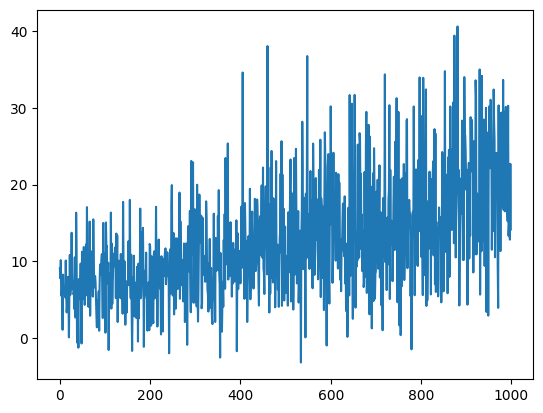

In [18]:
# -------------------------
# Main training loop
# -------------------------
def train():
    agent = DQNAgent(state_size=state_size, action_size=action_size, lr=1e-3, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.9995, memory_size=20000, batch_size=64, target_update_steps=2000)

    rewards_history = []
    bandwidth_history = []

    for ep in range(1, episodes + 1):
        Qlength = 0.0
        total_bandwidth_episode = 0.0
        total_reward_episode = 0.0

        for cycle_idx in range(cycles):
            state_vec = encode_state(cycle_idx, Qlength)
            action_idx = agent.act(state_vec)
            action_bandwidth = float(W_levels[action_idx])

            reward, Qlength_next, p_viloation, p_drop = env_rollout_one_cycle(cycle_idx, action_bandwidth, Qlength)

            next_state_vec = encode_state(min(cycle_idx + 1, cycles - 1), Qlength_next)
            done = 1.0 if cycle_idx == (cycles - 1) else 0.0

            # store transition (states are small vectors)
            agent.remember(state_vec, action_idx, reward, next_state_vec, done)

            # learn from memory
            agent.learn()

            # update for next cycle
            Qlength = Qlength_next
            total_reward_episode += reward
            total_bandwidth_episode += action_bandwidth

        rewards_history.append(total_reward_episode)
        bandwidth_history.append(total_bandwidth_episode)
        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)

    return rewards_history, bandwidth_history

if __name__ == "__main__":
    reward_history, bandwidth_history = train()
    plt.plot(reward_history)
    plt.show()
    